# fig — convergence

**Motivation**: host = ```mach```, device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 2
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:2  ———  host: mach

In [3]:
fig_dir = pjoin(fig_base_dir, 'iclr_oct02')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

['convergence_nelbo.pdf', 'rotate', 'convergence_mse.pdf', 'ood', 'recon']

## Load outside data

In [4]:
dekel_dir = '/home/hadi/Dropbox/git/jb-vae/tmp/dekel_data/'
mse_outside = pjoin(dekel_dir, 'mnist_mse_1000iter.npz')
mse_outside = dict(np.load(mse_outside, allow_pickle=True))
mse_outside = {
    'sa-VAE': mse_outside['semi'],
    'ia-VAE (hierarchical)': mse_outside['marino_h'],
    'ia-VAE (single-level)': mse_outside['marino_sl'],
}

## VAE: amort and iterative

### iP-VAE

In [5]:
mnist_to_load = get_mnist_models(device)
print(sorted(mnist_to_load))

[
    '<conv|conv>_(16,8.0)',
    '<conv|conv>_(4,1.5)',
    '<jacob|conv>_(16,8.0)',
    '<jacob|conv>_(2,0.75)',
    '<jacob|conv>_(4,1.5)',
    '<jacob|mlp>_(16,8.0)',
    '<jacob|mlp>_(4,1.5)',
    '<jacob|mlp>_(64,24.0)',
    '<mlp|mlp>_(16,8.0)',
    '<mlp|mlp>_(4,1.5)',
    '<mlp|mlp>_(64,24.0)'
]

In [6]:
selected_models = [
    '<jacob|mlp>_(4,1.5)',
    '<jacob|mlp>_(16,8.0)',
    '<jacob|mlp>_(64,24.0)',
    '<jacob|conv>_(4,1.5)',
    '<jacob|conv>_(16,8.0)',
]

### mk df

In [7]:
df = []

n_data_batches = 3
for name in tqdm(selected_models):
    tr, meta = load_model(
        **mnist_to_load[name])

    seq_total = 1 if tr.model.cfg.seq_len == 1 else 1000
    kws_analysis = dict(
        seq_total=seq_total,
        n_data_batches=n_data_batches,
        verbose=False,
    )
    results = tr.analysis('vld', **kws_analysis)
    
    df.append({
        'name': [name] * seq_total,
        'n_iters_train': [tr.model.cfg.seq_len] * seq_total,
        'beta': [tr.cfg.kl_beta] * seq_total,
        'time': range(seq_total),
        'mse': results['mse'],
        'nelbo': results['nelbo'],
        'lifetime': results['lifetime'],
    })

df = pd.DataFrame(merge_dicts(df))

100%|█████████████████████████████████████████████| 5/5 [02:58<00:00, 35.68s/it]


In [8]:
names = sorted(df['name'].unique())
print(names)

[
    '<jacob|conv>_(16,8.0)',
    '<jacob|conv>_(4,1.5)',
    '<jacob|mlp>_(16,8.0)',
    '<jacob|mlp>_(4,1.5)',
    '<jacob|mlp>_(64,24.0)'
]

In [9]:
def _subplot(
        ax,
        data,
        label,
        legend_title='',
        intvl=None,
        legend=True,
        annot=False,
        xscale='log',
        yscale='log',
        **kwargs, ):
    defaults = {
        'figsize_x': 5.0,
        'figsize_y': 3.0,
        'legend_fontsize': 10,
        'color': 'C0',
        'marker': '.',
        'markersize': 6,
        'lw': 1,
    }
    kwargs = setup_kwargs(defaults, kwargs)
    _intvl = intvl or range(0, len(data))
    _intvl = range(
        _intvl.start,
        min(_intvl.stop, len(data)),
        _intvl.step,
    )
    y = data[_intvl]

    if _intvl.start == 0:
        xs = [i + 1 for i in _intvl]
        shifted = True
    else:
        xs = list(_intvl)
        shifted = False
    
    ax.plot(
        xs, y,
        label=label,
        color=kwargs['color'],
        marker=kwargs['marker'],
        markersize=kwargs['markersize'],
        lw=kwargs['lw'],
    )
    # y_smooth = cumulative_mean(y)

    if annot:
        fmt = '0.2g' if y[-1] > 1000 else '0.2f'
        label = r"$\lim_{t \rightarrow \infty}: $"
        label += f" {y[-1]:{fmt}}"
        ax.axhline(y[-1], color='dimgrey', ls='--')
        ax.annotate(
            text=label,
            xy=(0.02, y[-1]),
            xytext=(0, -14 if y[-1] > 1000 else 13),
            xycoords=('axes fraction', 'data'),
            textcoords='offset points',
            color='dimgrey',
            fontsize=13,
        )
    ax.set(xscale=xscale, yscale=yscale)
    if legend:
        ax.legend(title=legend_title, fontsize=kwargs['legend_fontsize'])
    # ax.grid()
    return ax

In [10]:
pal_models = get_palette_models()
cube_1, cube_2 = get_palette_cube()

display(cube_1)
display(cube_2)

[[0.5824870441488921, 0.7363453335709885, 0.8433717011545296],
 [0.3539515775044114, 0.546748869622813, 0.6653947680423337],
 [0.16988211962067074, 0.3386232545510099, 0.4298800647405776]]

[[0.8645027806639409, 0.6130500616242651, 0.7355509855551107],
 [0.69406441420036, 0.39526932513071356, 0.5502981253898998],
 [0.456754933872734, 0.20850154256328235, 0.3454274980888438]]

In [11]:
selected_models = {
    'mlp': ['(4,1.5)', '(16,8.0)', '(64,24.0)'],
    'conv': ['(4,1.5)', '(16,8.0)'],
}
pal = {
    'mlp': dict(zip(selected_models['mlp'], cube_1)),
    'conv': dict(zip(selected_models['conv'], cube_2)),
}

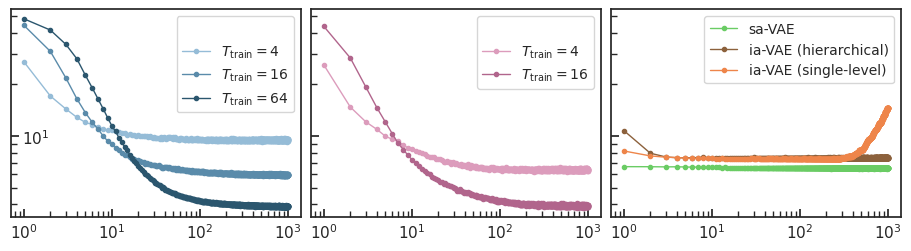

In [12]:
fig, axes = create_figure(1, 3, (9.0, 2.4), sharex='all', sharey='all')

for i, (archi, selected) in enumerate(selected_models.items()):
    for item in selected:
        name = f'<jacob|{archi}>_{item}'
        _df = df.loc[df['name'] == name]
        if not len(_df):
            continue
        x2p = _df['mse'].to_numpy()
    
        ax = axes[i]
        label = r"$T_\text{train} = $"
        label += str(_df['n_iters_train'].unique().item())
        ax = _subplot(ax, x2p, label, color=pal[archi][item], legend_title=' ', legend=True)
        ax.tick_params(direction='in', which='both')

# ax = axes[2]
# label = 'ia-VAE'
# ax = _subplot(ax, np.random.randn(1000) ** 2 + 4, label, color=pal_models[label], legend=True)
# ax.tick_params(direction='in', which='both')

ax = axes[2]
for label, x2p in mse_outside.items():
    ax = _subplot(ax, x2p[1:], label, color=pal_models[label], legend=True)
ax.tick_params(direction='in', which='both')

axes[0].tick_params(axis='y', pad=-28)

In [13]:
fig.savefig(pjoin(fig_dir, 'convergence_mse.pdf'), **kws_fig)

In [14]:
_df = df.loc[df['name'] == '<jacob|conv>_(16,8.0)']
_df['mse'][-3:].to_numpy()

array([3.9314213, 3.8932683, 3.8784432], dtype=float32)

In [15]:
_df = df.loc[df['name'] == '<jacob|mlp>_(64,24.0)']
_df['mse'][-3:].to_numpy()

array([3.9127743, 3.931196 , 3.928501 ], dtype=float32)

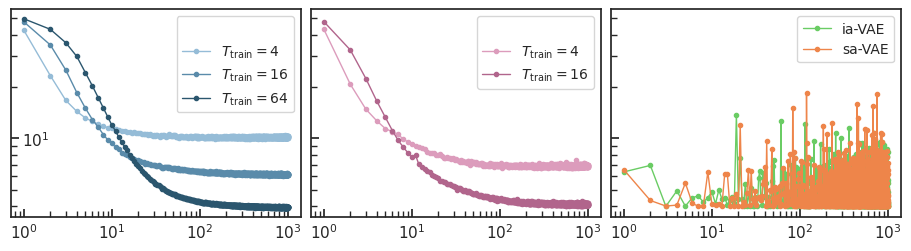

In [15]:
fig, axes = create_figure(1, 3, (9.0, 2.4), sharex='all', sharey='all')

for i, (archi, selected) in enumerate(selected_models.items()):
    for item in selected:
        name = f'<jacob|{archi}>_{item}'
        _df = df.loc[df['name'] == name]
        if not len(_df):
            continue
        x2p = _df['nelbo'].to_numpy()
    
        ax = axes[i]
        label = r"$T_\text{train} = $"
        label += str(_df['n_iters_train'].unique().item())
        ax = _subplot(ax, x2p, label, color=pal[archi][item], legend_title=' ', legend=True)
        ax.tick_params(direction='in', which='both')

ax = axes[2]
label = 'ia-VAE'
ax = _subplot(ax, np.random.randn(1000) ** 2 + 4, label, color=pal_models[label], legend=True)
ax.tick_params(direction='in', which='both')

label = 'sa-VAE'
ax = _subplot(ax, np.random.randn(1000) ** 2 + 4, label, color=pal_models[label], legend=True)
ax.tick_params(direction='in', which='both')

axes[0].tick_params(axis='y', pad=-28)

In [16]:
fig.savefig(pjoin(fig_dir, 'convergence_nelbo.pdf'), **kws_fig)

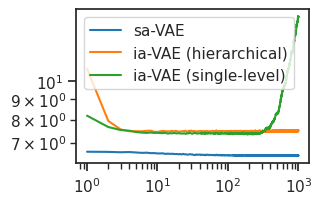

In [46]:
for k, v in mse_outside.items():
    plt.loglog(np.arange(1, len(v)), v[1:], label=k)
plt.legend()

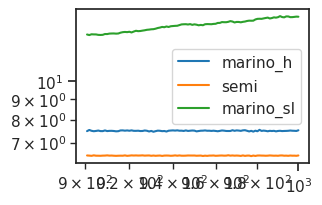

In [43]:
num = 100

for k, v in mse_outside.items():
    plt.loglog(np.arange(len(v) - num, len(v)), v[-num:], label=k)
plt.legend()

In [44]:
mse_outside

{'marino_h': array([101.22117  ,  10.753565 ,   7.939746 , ...,   7.4936156,
          7.4870305,   7.516615 ], dtype=float32),
 'semi': array([6.6530576, 6.6335173, 6.6277094, ..., 6.483411 , 6.4779816,
        6.4904175], dtype=float32),
 'marino_sl': array([99.87574  ,  8.185052 ,  7.6615477, ..., 14.556963 , 14.579315 ,
        14.570363 ], dtype=float32)}